# California Housing Project

This lab shows the importance of location in the pricing of housing in California, showing that location along can account for 75% of the variation in housing prices.  The lab uses older data, obtained during the 1990 Census. 
- The **first model** considers the house's simple geographic region and accounts for **20%** of the variation in housing price.
- The **second model** considers the house's distance to large cities and accounts for **25%** of variation.
- The **final model** considers the price of nearby homes and accounts for **75%** of the variation.

## EDA
Load the dataset, look for correlation between housing features and housing price


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import json

from geopy.distance import geodesic

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [2]:
housing = fetch_california_housing()

df = pd.DataFrame(housing.data, columns=housing.feature_names)
df["housing_price"] = pd.DataFrame(housing.target, columns=housing.target_names)
df.dropna(axis=1, inplace=True)
#print(df.head().to_markdown())
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,housing_price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We see a **strong correlation** of both **Medium Income** (MedInc) **location** with housing price.  The highest priced housing can be found in the San Francisco, L.A., and San Diego regions, while the lower priced housing is in the Central Valley.

In [3]:
x = pd.DataFrame(df[["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "housing_price"]].corr()["housing_price"])
x.columns=["Price Correlation"]
x = x.drop("housing_price").sort_values(by="Price Correlation", ascending=False)

#print(x.to_markdown(index=True))
x

,Price Correlation
MedInc,0.688075
AveRooms,0.151948
HouseAge,0.105623
AveOccup,-0.023737
Population,-0.024650
AveBedrms,-0.046701


In [4]:
map1 = px.scatter_map(df, lat="Latitude", lon="Longitude", color="housing_price", width=600, height=600, center={"lat":36.43, "lon":-119.97}, zoom=5,
               title = "Housing Price (1990) by Location ($100,000)")

map1.write_image("img/map1.png")

<img src="img/map1.png">

## First Simple Model: Region of Housing
As a simple initial model, we will model housing_price by 5 regions, which ultimately accounts for 20% of the variation in housing price.
The model assigns these housing prices based on region, as discovered during model fitting:
- San Francisco Region:
- Los Angeles Region:
- San Diego Region:
- Central Valley Region:
- Other Region: 

First, determine whether each housing block falls in a particular region.  Then, build and inspect a linear model of housing prices.

In [5]:
regions = {"sf_region": {"h":(38.09, -122.61), "k":(36.96, -121.99), "r":95},
           "la_region": {"h":(34.11, -118.51), "k":(33.85, -117.85), "r":60},
           "sd_region": {"h":(33.09, -117.14), "k":(32.67, -117.01), "r":42},
           "central_valley": {"h":(38.83, -121.18), "k":(36.5, -119.36), "r":194}}

def in_region(region, point):
    return (geodesic(region["h"], point).mi + geodesic(region["k"], point).mi) < region["r"]

for region in regions:
    df[region] = df[["Latitude", "Longitude"]].apply(lambda x: in_region(regions[region], (x.iloc[0], x.iloc[1])), axis=1);

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df[["sf_region", "la_region", "sd_region", "central_valley"]], df["housing_price"], 
                                                    test_size=0.2, random_state=42)

lr = LinearRegression()

lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.19510037086082188

In [7]:
samples = np.vstack([np.identity(4), [0,0,0,0]])
samples = pd.DataFrame(samples, columns=X_train.columns)
samples.index = ["SF Region", "LA Region", "SD Region", "Central Valley", "Other"]

predictions = lr.predict(samples)
prices = pd.DataFrame(zip(samples.index, predictions), columns=["Region", "Housing Price ($ 100,000s)"])
# print(prices.to_markdown(index=False))
prices


,Region,"Housing Price ($ 100,000s)"
0,SF Region,2.838085
1,LA Region,2.390499
2,SD Region,1.975643
3,Central Valley,1.075977
4,Other,1.628394


In [8]:
df["model_one_errors"] = df["housing_price"] - lr.predict(df[["sf_region", "la_region", "sd_region", "central_valley"]])
map_model_one_error = px.scatter_map(df, lat="Latitude", lon="Longitude", color="model_one_errors", width=1000, height=600, 
               center={"lat":33.92, "lon":-117.97}, zoom=8, title="Errors in Model One ($100,000s)")

map_model_one_error.write_image("img/map_model_one_error.png")

<img src="img/map_model_one_error.png">

## Second Simple Model: Inverse Distance to City
This model looks at price compared the to inverse distance to several desirable cities to live.

In [9]:
desirable_cities = {"san_rafael": (37.97,-122.53), "san_francisco": (37.77, -122.45), 
                    "san_mateo":(37.55, -122.31), "redwood_city": (37.43, -122.13),
                    "mountain_view":(37.37, -122.07), "cupertino": (37.32, -122.02),
                    "montery":(36.59, -121.93), "santa_barbara": (34.41, -119.71),
                    "la_beach":(33.82, -118.38),
                    "santa_monica":(34.03, -118.47), "san_diego": (32.08, -117.24)}

def inverse_distance(location, desirable_city):
    return 1/(1+geodesic(location, desirable_city).mi)

In [10]:
for city in desirable_cities:
  df[city] = df[["Latitude", "Longitude"]].apply(lambda x: inverse_distance(desirable_cities[city], (x.iloc[0], x.iloc[1])), axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df[desirable_cities.keys()], df["housing_price"], test_size=0.2)

lr_model_two = LinearRegression()

lr_model_two.fit(X_train, y_train)
lr_model_two.score(X_test, y_test)

0.31015085618508265

<Axes: xlabel='model_two_residuals', ylabel='Count'>

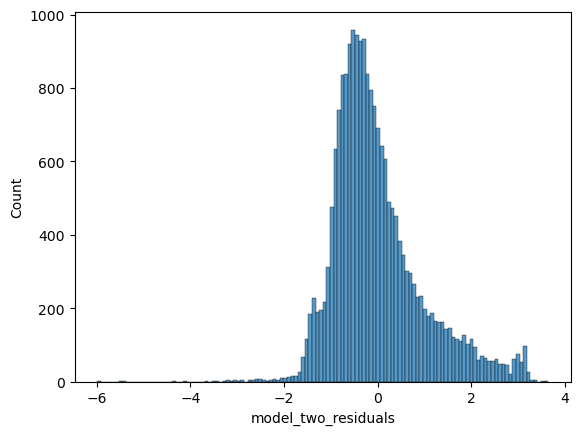

In [12]:
df["model_two_residuals"] = df["housing_price"] - lr_model_two.predict(df[desirable_cities.keys()])

sns.histplot(df["model_two_residuals"])

In [13]:
map_model_two_error = px.scatter_map(df, lat="Latitude", lon="Longitude", color="model_two_residuals", width=1000, height=600, 
               center={"lat":33.92, "lon":-117.97}, zoom=8, title="Errors in Model Two ($100,000s)")

map_model_two_error.write_image('img/map_model_two_error.png')

<img src="img/map_model_two_error.png">

## Third Model: Nearest Neighbors
Considering the average housing prices of the 8 nearest housing units models 79% of the pricing variation.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df[["Latitude", "Longitude"]], df["housing_price"])

gs = GridSearchCV(estimator=KNeighborsRegressor(), param_grid={"n_neighbors":[2,3,4,5,10,15,30]}, cv=5)

gs.fit(X_train, y_train)

gs.score(X_test, y_test)


0.7917831940223699

<Axes: xlabel='model_three_residuals', ylabel='Count'>

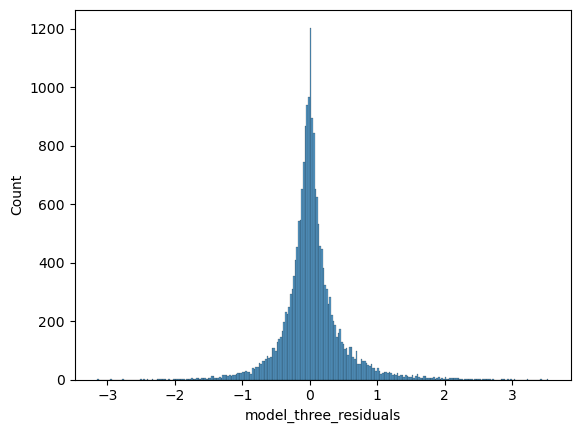

In [15]:
df["model_three_residuals"] = df["housing_price"] - gs.predict(df[["Latitude", "Longitude"]])
sns.histplot(df["model_three_residuals"])

In [16]:
map_model_three_error = px.scatter_map(df, lat="Latitude", lon="Longitude", color="model_three_residuals", width=1000, height=600, 
               center={"lat":33.92, "lon":-117.97}, zoom=8, title="Errors in Model Three ($100,000s)")

map_model_three_error.write_image('img/map_model_three_error.png')

<img src="img/map_model_three_error.png">

## Fourth Model: Zipcodes
In the final model, we calculate the median housing_price by zip code from training data, and determine it to be the best model of all.

In [35]:
df = pd.read_csv("Data/housing.csv")
df.dropna(axis=0, inplace=True)

X_train, X_test = train_test_split(df[["Latitude", "Longitude", "zipcode", "housing_price"]], test_size=0.2, random_state=42)

price_median = X_train.groupby("zipcode").median()
price_count = X_train.groupby("zipcode").count()

price_median["count"] = price_count["housing_price"]

X_test["prediction"] = X_test["zipcode"].map(lambda x: price_median.loc[x]["housing_price"] if x in price_median.index else np.nan)

X_test["model_four_residuals"] = (X_test["prediction"] - X_test["housing_price"]) 
X_test["account"] = (X_test["prediction"] - X_test["housing_price"].mean())/(X_test["housing_price"] - X_test["housing_price"].mean())
X_test["account"].mean()

1.1326685028179881

<Axes: xlabel='model_four_residuals', ylabel='Count'>

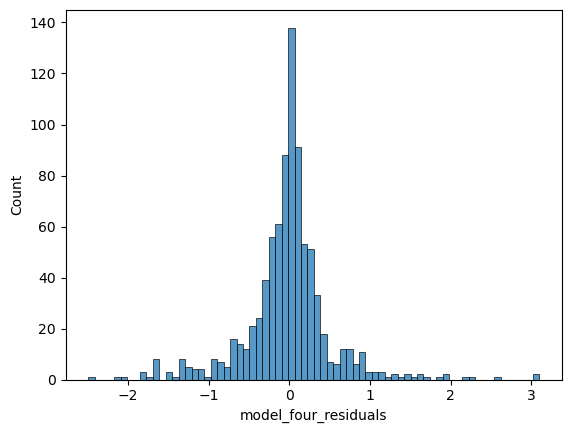

In [31]:
sns.histplot(X_test["model_four_residuals"])

In [34]:
map_model_four_error = px.scatter_map(X_test, lat="Latitude", lon="Longitude", color="model_four_residuals", width=1000, height=600, 
               center={"lat":33.92, "lon":-117.97}, zoom=8, title="Errors in Model Four ($100,000s)")

map_model_four_error.write_image('img/map_model_four_error.png')
map_model_four_error.show()

<img src="img/map_model_four_error.png">

## Conclusion
It turns out that the best predictor of a housing price is the average price of the 5 nearest blocks.  Since housing is often built in developments of similar housing, it makes sense that the neighborhood would have the strongest effect on housing price.